## Training and deploying logo detector with GluonCV

This notebook performs image exploration, training, and deployment.

Some notes about the setup:
- Images were downloaded from Google search using Bulk Image Downloader tool in Chrome
- Images are labeled using AWS SageMaker Ground Truth
- Exploration, training, and deployment takes place in SageMaker Notebook instance with conda_mxnet_p36 kernel

First we install GluonCV, load modules, define a SageMaker execution role, and specifiy S3 bucket.

In [ ]:
!pip install gluoncv

In [ ]:
import sagemaker
import mxnet as mx
import matplotlib.pyplot as plt
from sagemaker.mxnet import MXNet
from gluoncv import model_zoo, data, utils
import gluoncv as gcv
import glob
import math
import numpy as np
import json
import cv2
import os
import tarfile

In [21]:
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()
bucket='bcbs-logos'

### Transfer learning: detect logos with pre-trained SSD model

We will use SageMaker Groundtruth to train GluonCV's SSD model to detect AWS logos. 

In [26]:
# Download output.manifest from bucket
if not os.path.isfile('output.manifest'):
    import boto3
    s3 = boto3.resource('s3')
    s3.Bucket(bucket).download_file('label/bcbs-logos/manifests/output/output.manifest', 'output.manifest')    

On each image, there is one or more logos. We can read this information from the `output.manifest` file.

In [27]:
image_info = []
with open('output.manifest') as f:
    lines = f.readlines()
    for line in lines:
        image_info.append(json.loads(line[:-1]))

In [38]:
info = image_info[0]
print("Ground Truth labeling for sample image:")
info

Ground Truth labeling for sample image:


{'source-ref': 's3://bcbs-logos/images (1).jpg',
 'bcbs-logos': {'annotations': [{'class_id': 0,
    'width': 27,
    'top': 63,
    'height': 32,
    'left': 94}],
  'image_size': [{'width': 318, 'depth': 3, 'height': 159}]},
 'bcbs-logos-metadata': {'job-name': 'labeling-job/bcbs-logos',
  'class-map': {'0': 'logo'},
  'human-annotated': 'yes',
  'objects': [{'confidence': 0.09}],
  'creation-date': '2019-12-03T20:13:21.115050',
  'type': 'groundtruth/object-detection'}}

Let's plot some of the labels:

In [39]:
task = "bcbs-logos"
class_map = info[task+'-metadata']['class-map']
image = plt.imread(os.path.join("images",info['source-ref'].split('/')[-1]))
boxes = info[task]['annotations']
boxes

[{'class_id': 0, 'width': 27, 'top': 63, 'height': 32, 'left': 94}]

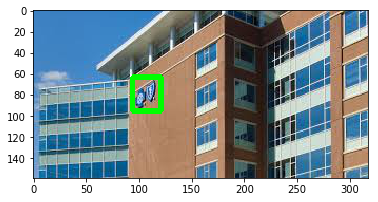

In [40]:
for box in boxes:
    cv2.rectangle(image, (int(box['left']), int(box['top'])), (int(box['left']+box['width']), int(box['top']+box['height'])), (0,255,0), 3)
plt.imshow(image)
plt.show()

### Transfer learning: detect AWS logos with pre-trained SSD model

We will use SageMaker Groundtruth to train GluonCV's SSD model to detect AWS logos. 

In [41]:
mxnet_estimator = MXNet(entry_point='train_bcbs_logo_detection_ssd.py',
                        source_dir='entry_point',
                        role=role,
                        train_instance_type='ml.p2.xlarge',
                        train_instance_count=1,
                        framework_version='1.4.0', py_version='py3')

In [42]:
s3_train_data = 's3://bcbs-logos/logos'
s3_label_data = 's3://bcbs-logos/label/bcbs-logos/manifests/output'

In [43]:
mxnet_estimator.fit({'train': s3_train_data, 'labels': s3_label_data})

2019-12-07 19:04:14 Starting - Starting the training job...
2019-12-07 19:04:39 Starting - Launching requested ML instances.........
2019-12-07 19:05:47 Starting - Preparing the instances for training............
2019-12-07 19:07:50 Downloading - Downloading input data......
2019-12-07 19:09:14 Training - Training image download completed. Training in progress..2019-12-07 19:09:15,814 sagemaker-containers INFO     Imported framework sagemaker_mxnet_container.training
2019-12-07 19:09:15,841 sagemaker_mxnet_container.training INFO     MXNet training environment: {'SM_HOSTS': '["algo-1"]', 'SM_NETWORK_INTERFACE_NAME': 'eth0', 'SM_HPS': '{}', 'SM_USER_ENTRY_POINT': 'train_bcbs_logo_detection_ssd.py', 'SM_FRAMEWORK_PARAMS': '{}', 'SM_RESOURCE_CONFIG': '{"current_host":"algo-1","hosts":["algo-1"],"network_interface_name":"eth0"}', 'SM_INPUT_DATA_CONFIG': '{"labels":{"RecordWrapperType":"None","S3DistributionType":"FullyReplicated","TrainingInputMode":"File"},"train":{"RecordWrapperType":"No

In [14]:
predictor = mxnet_estimator.deploy(
            instance_type='ml.m5.xlarge', 
            initial_instance_count=1,
            endpoint_name="gluoncv-bcbs-logo-detection"
)

---------------------------------------------------------------------------------------------------!

### Optimize the model for inference with SageMaker Neo

In [73]:
output_path="s3://neo-compiled-models"

Create compilation job: We optimize the model for a c5 instance. 

In [74]:
compiled_model = mxnet_estimator.compile_model(target_instance_family='ml_c5', 
                                               input_shape={'data':[1,3,512,512]},
                                               role=role,
                                               output_path=output_path)

?.......!

In [77]:
predictor_optimized = compiled_model.deploy(initial_instance_count = 1, 
                                            instance_type = 'ml.c5.4xlarge',
                                            endpoint_name="gluoncv-aws-logo-detection-neo")

--------------------------------------------------------------------------------------!